In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-08-31 20:34:08.107949: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 20:34:08.365547: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 20:34:08.368183: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 20:34:10.551729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
np.random.seed(333)
tf.random.set_seed(333)
assert tf.__version__.startswith('2.'), "TensorFlow Version Below 2.0"

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train.astype(np.float32)/255., x_test.astype(np.float32)/255.
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


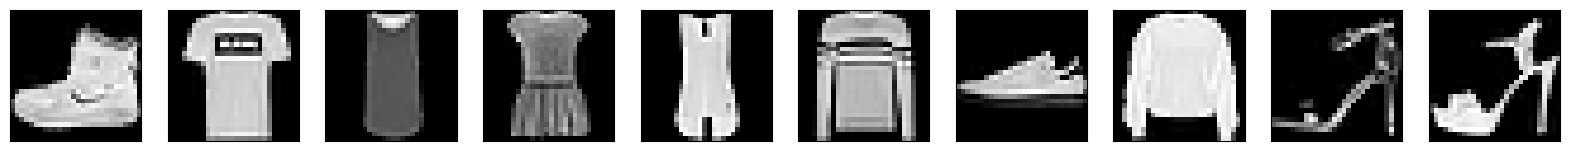

In [4]:
number = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_train[index], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
image_size = x_train.shape[1]*x_train.shape[2]
hidden_dim = 512
latent_dim = 10
num_epochs = 40
batch_size = 100
learning_rate = 0.001

In [6]:
class VAE(tf.keras.Model):
    def __init__(self,dim,**kwargs):
        h_dim = dim[0]
        z_dim = dim[1]
        super(VAE, self).__init__(**kwargs)

        self.fc1 = tf.keras.layers.Dense(h_dim)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)

        self.fc4 = tf.keras.layers.Dense(h_dim)
        self.fc5 = tf.keras.layers.Dense(image_size)

    def encode(self, x):
        h = tf.nn.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)
        return mu + eps * std

    def decode_logits(self, z):
        h = tf.nn.relu(self.fc4(z))
        return self.fc5(h)

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_reconstructed_logits = self.decode_logits(z)
        return x_reconstructed_logits, mu, log_var

In [7]:
model = VAE([hidden_dim, latent_dim])
model.build(input_shape=(4, image_size))
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate)

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  401920    
                                                                 
 dense_1 (Dense)             multiple                  5130      
                                                                 
 dense_2 (Dense)             multiple                  5130      
                                                                 
 dense_3 (Dense)             multiple                  5632      
                                                                 
 dense_4 (Dense)             multiple                  402192    
                                                                 
Total params: 820004 (3.13 MB)
Trainable params: 820004 (3.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-31 20:34:14.943620: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)

num_batches = x_train.shape[0] // batch_size

for epoch in range(num_epochs):
    for step, x in enumerate(dataset):
        x = tf.reshape(x, [-1, image_size])

        with tf.GradientTape() as tape:
            # Forward pass
            x_reconstruction_logits, mu, log_var = model(x)

            # Compute reconstruction loss and kl divergence
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size
            kl_div = - 0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            # Backprop and optimize
            loss = tf.reduce_mean(reconstruction_loss) + kl_div

        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if (step + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                  .format(epoch + 1, num_epochs, step + 1, num_batches, float(reconstruction_loss), float(kl_div)))

Epoch[1/40], Step [50/600], Reconst Loss: 306.6691, KL Div: 12.2401
Epoch[1/40], Step [100/600], Reconst Loss: 273.2680, KL Div: 14.1308
Epoch[1/40], Step [150/600], Reconst Loss: 270.1107, KL Div: 13.7649
Epoch[1/40], Step [200/600], Reconst Loss: 254.6690, KL Div: 14.8255
Epoch[1/40], Step [250/600], Reconst Loss: 256.2044, KL Div: 14.2509
Epoch[1/40], Step [300/600], Reconst Loss: 271.0750, KL Div: 15.9300
Epoch[1/40], Step [350/600], Reconst Loss: 246.8448, KL Div: 14.4966
Epoch[1/40], Step [400/600], Reconst Loss: 249.4990, KL Div: 13.7246
Epoch[1/40], Step [450/600], Reconst Loss: 232.7157, KL Div: 13.9337
Epoch[1/40], Step [500/600], Reconst Loss: 239.4519, KL Div: 14.3168
Epoch[1/40], Step [550/600], Reconst Loss: 254.6404, KL Div: 14.5973
Epoch[1/40], Step [600/600], Reconst Loss: 247.6461, KL Div: 14.3196
Epoch[2/40], Step [50/600], Reconst Loss: 252.2133, KL Div: 16.1241
Epoch[2/40], Step [100/600], Reconst Loss: 250.3927, KL Div: 14.1921
Epoch[2/40], Step [150/600], Reconst

Epoch[10/40], Step [600/600], Reconst Loss: 220.9370, KL Div: 14.4391
Epoch[11/40], Step [50/600], Reconst Loss: 234.9324, KL Div: 14.5309
Epoch[11/40], Step [100/600], Reconst Loss: 224.9385, KL Div: 15.5163
Epoch[11/40], Step [150/600], Reconst Loss: 248.1413, KL Div: 15.0527
Epoch[11/40], Step [200/600], Reconst Loss: 218.9927, KL Div: 15.3750
Epoch[11/40], Step [250/600], Reconst Loss: 239.2527, KL Div: 15.2695
Epoch[11/40], Step [300/600], Reconst Loss: 227.1260, KL Div: 14.2714
Epoch[11/40], Step [350/600], Reconst Loss: 235.5843, KL Div: 15.4563
Epoch[11/40], Step [400/600], Reconst Loss: 229.1404, KL Div: 15.4985
Epoch[11/40], Step [450/600], Reconst Loss: 226.4021, KL Div: 15.1539
Epoch[11/40], Step [500/600], Reconst Loss: 235.4742, KL Div: 14.5197
Epoch[11/40], Step [550/600], Reconst Loss: 232.1326, KL Div: 14.9261
Epoch[11/40], Step [600/600], Reconst Loss: 231.6228, KL Div: 14.3725
Epoch[12/40], Step [50/600], Reconst Loss: 221.2918, KL Div: 15.1090
Epoch[12/40], Step [10

Epoch[20/40], Step [500/600], Reconst Loss: 227.1585, KL Div: 15.3663
Epoch[20/40], Step [550/600], Reconst Loss: 225.1069, KL Div: 14.9705
Epoch[20/40], Step [600/600], Reconst Loss: 231.3156, KL Div: 15.1539
Epoch[21/40], Step [50/600], Reconst Loss: 232.0064, KL Div: 15.7011
Epoch[21/40], Step [100/600], Reconst Loss: 207.0504, KL Div: 15.6011
Epoch[21/40], Step [150/600], Reconst Loss: 232.1460, KL Div: 14.5041
Epoch[21/40], Step [200/600], Reconst Loss: 221.2928, KL Div: 15.2605
Epoch[21/40], Step [250/600], Reconst Loss: 227.7144, KL Div: 15.3210
Epoch[21/40], Step [300/600], Reconst Loss: 223.1515, KL Div: 15.2553
Epoch[21/40], Step [350/600], Reconst Loss: 232.7027, KL Div: 15.8951
Epoch[21/40], Step [400/600], Reconst Loss: 224.9304, KL Div: 15.6779
Epoch[21/40], Step [450/600], Reconst Loss: 222.6341, KL Div: 15.5372
Epoch[21/40], Step [500/600], Reconst Loss: 227.2047, KL Div: 14.8099
Epoch[21/40], Step [550/600], Reconst Loss: 223.9408, KL Div: 15.5435
Epoch[21/40], Step [6

Epoch[30/40], Step [400/600], Reconst Loss: 232.1431, KL Div: 15.5344
Epoch[30/40], Step [450/600], Reconst Loss: 224.1168, KL Div: 15.7226
Epoch[30/40], Step [500/600], Reconst Loss: 228.5110, KL Div: 15.9910
Epoch[30/40], Step [550/600], Reconst Loss: 218.2711, KL Div: 15.1492
Epoch[30/40], Step [600/600], Reconst Loss: 225.3898, KL Div: 15.6228
Epoch[31/40], Step [50/600], Reconst Loss: 231.1064, KL Div: 15.9546
Epoch[31/40], Step [100/600], Reconst Loss: 222.5357, KL Div: 15.3332
Epoch[31/40], Step [150/600], Reconst Loss: 237.4722, KL Div: 14.9412
Epoch[31/40], Step [200/600], Reconst Loss: 224.2950, KL Div: 14.6648
Epoch[31/40], Step [250/600], Reconst Loss: 234.7148, KL Div: 14.9054
Epoch[31/40], Step [300/600], Reconst Loss: 213.1173, KL Div: 15.7751
Epoch[31/40], Step [350/600], Reconst Loss: 220.7345, KL Div: 16.0903
Epoch[31/40], Step [400/600], Reconst Loss: 222.8084, KL Div: 15.9441
Epoch[31/40], Step [450/600], Reconst Loss: 217.5889, KL Div: 14.8190
Epoch[31/40], Step [5

Epoch[40/40], Step [300/600], Reconst Loss: 217.9633, KL Div: 16.0659
Epoch[40/40], Step [350/600], Reconst Loss: 245.1233, KL Div: 15.8889
Epoch[40/40], Step [400/600], Reconst Loss: 234.9475, KL Div: 15.2585
Epoch[40/40], Step [450/600], Reconst Loss: 225.7557, KL Div: 15.5806
Epoch[40/40], Step [500/600], Reconst Loss: 231.3794, KL Div: 14.8607
Epoch[40/40], Step [550/600], Reconst Loss: 225.8228, KL Div: 14.9730
Epoch[40/40], Step [600/600], Reconst Loss: 229.5264, KL Div: 15.9809


In [9]:
z = tf.random.normal((batch_size, latent_dim))
out = model.decode(z)  # decode with sigmoid
out = tf.reshape(out, [-1, 28, 28]).numpy() * 255
out = out.astype(np.uint8)

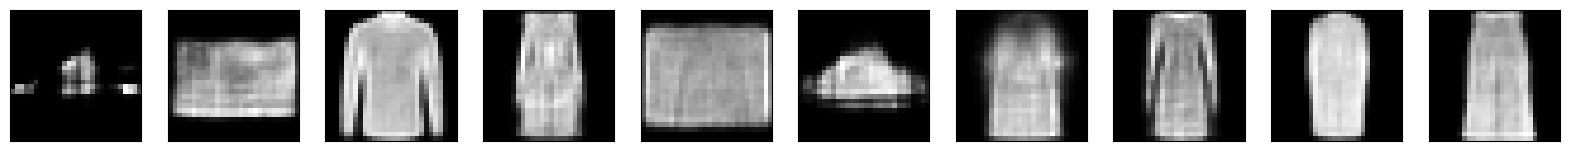

In [10]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(out[index], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

---